Volatility of stock returns refers to the degree of variation or fluctuation in the price or value of a stock over a specific period of time. It is a measure of the uncertainty or risk associated with the stock's performance. Generally, stocks with higher volatility are considered riskier because their prices can experience larger and more frequent swings.

Volatility is often quantified using statistical measures such as standard deviation or variance. These measures capture the dispersion of stock returns around their average or expected value. A higher standard deviation or variance indicates a greater level of volatility.

Volatility can be caused by various factors, including market conditions, economic indicators, company-specific news or events, and investor sentiment. It is important for investors and traders to understand the volatility of a stock because it can affect investment decisions, risk management strategies, and the potential for both gains and losses.

It's worth noting that there are different types of volatility measures, such as historical volatility (calculated using past price data) and implied volatility (derived from options prices), each serving different purposes in financial analysis and decision-making.

In [1]:
# In this we know how to model the volatility of stock return
#--------------------ARCH-GARCH----------------------------
# update statsmodels and install arch @ same time
!pip install -U arch statsmodels   

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from arch import arch_model     

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
def date_parser(date):
    return pd.to_datetime(date, format='%d-%m-%Y')

# Read the CSV file with the custom date parser
df = pd.read_csv('SPY.csv', parse_dates=True, index_col='Date', date_parser=date_parser)


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,92.246048,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.490204,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.555328,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.946060,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,93.255348,126402800


In [5]:
# calculates the logarithmic returns based on the 'Close' prices of an asset and adds them as a new column 
# named 'LogRet' in the DataFrame df
df['LogRet'] = np.log(df['Close']).diff() # compute log returns, which is time series we trying to model with GARCH 
# it take Close col take log and then take consecutive difference
# df.head() # tocheck how dataframe look like

In [6]:
# Now make a new dataframe which take everything except the 1st row, since it now contain any value for return
df2 =df.iloc[1:].copy()
# df2.head()

<AxesSubplot:xlabel='Date'>

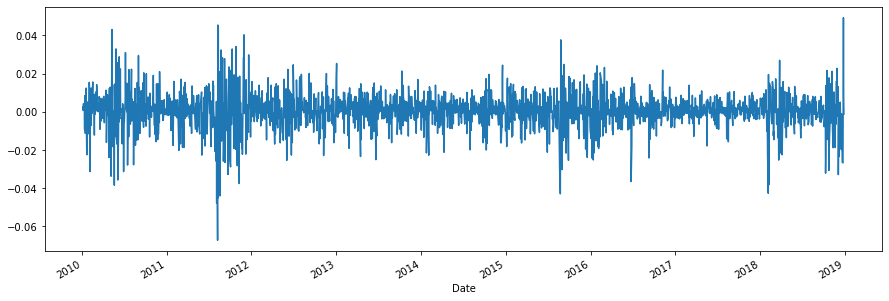

In [7]:
# plot log(return)
df2['LogRet'].plot(figsize=(15,5))
# As expected, we see a lot of volatility clustering every time the return has a large magnitude, it surrounded by other
# return of large magnitude

<AxesSubplot:xlabel='Date'>

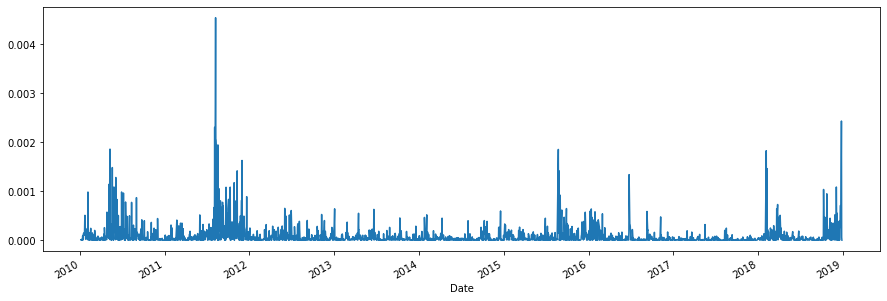

In [8]:
# compute square of log return and plot it 
df2['Ysq'] = df['LogRet']**2
df2['Ysq'].plot(figsize=(15,5))

# This make easier to see that volatility does in fact cluster when the returns get large, they are usually followed by 
# more large returns.
# df2.head()

# ACF and PACF

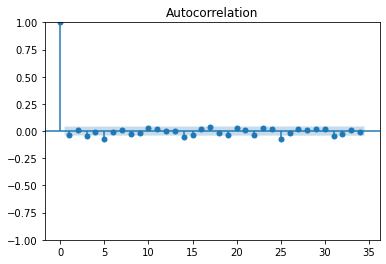

In [9]:
plot_acf(df2['LogRet'])
plt.show()
# As expected their is no significant correlation, there are couple of values go outside significant threshold But this
# also happen due to IID noise as well. Furthermore, as you recall, with a 5% significant threshold we do expect to see
# False positive 5% of the time.
# so error are linearlly Independent 

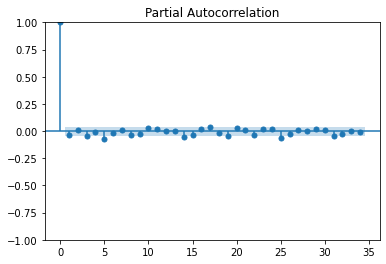

In [10]:
plot_pacf(df2['LogRet'])
plt.show()
# see the same thing as the ACF
# again the same error are linearlly Independent 

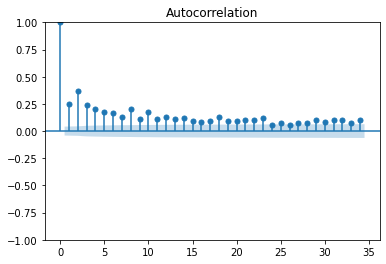

In [11]:
# Now plot ACF of Squared returned 
plot_acf(df2['Ysq'])
plt.show()
# so as we can see their are many Significant lags --> there is significant correlation in the Squared series.

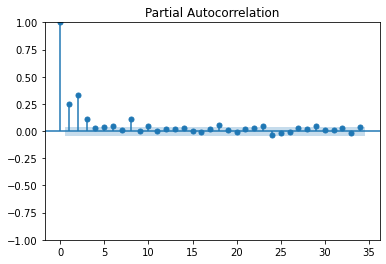

In [12]:
# Now plot PACF of Squared returned 
plot_pacf(df2['Ysq'])
plt.show()
# so again we see that there are some very significant lags going far beyond the significance threshold

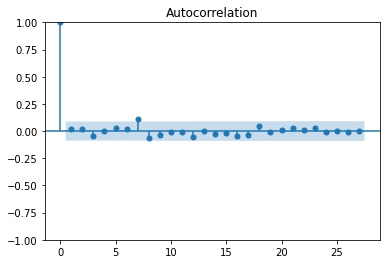

In [13]:
# So we've seen that ACF & PACF for log return look loke a random walk But ACF & PACF for Squared return have 
# sifnificant lags (by defination we know that if we plot ACF & PACF of Gaussian white Noise we would see the same thing)
# Now also see the ACF & PACF of Gaussian white noise 
# So generate 500 points from standard normal, which give Gaussian white noise and squared these values and also plot ACF.
noise_sq = np.random.randn(500)**2
plot_acf(noise_sq)
plt.show()
# As epected ACF show no significant lags
# so this ans the que this is the thing that differentiates stock returns from actual Gausian white noice

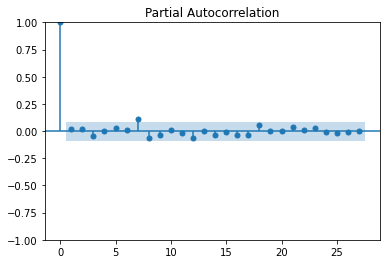

In [14]:
# plot pacf
plot_pacf(noise_sq)
plt.show()
#got same thing as acf

so, We learned that dependent in square returned tells us that stock price returns are not exactly like Gaussian 
white noise used to produce a random walk. we've seen that because Gaussian white noise are truly Independent there will
not be any autocorrelation no matter how you transform the series.

Train-Test Split

In [15]:
# creating Train-Test split og log return
Ntest = 500    # no specific reason can be selected any value
train = df2.iloc[:-Ntest][['LogRet']].copy()
test = df2.iloc[-Ntest:][['LogRet']].copy()
# Train.head() #test.head()

In [16]:
# Need of Scale return while using GARCH
model = arch_model(train['LogRet'], vol = 'GARCH', p=1, q=1) # 1st argument training time series GARCH(1,1)


In [17]:
res = model.fit() 
# This print lost fun at each iteration, we also get a warning that scale of y is small and say parameter estimation works 
# better when this value is b/w 1 and 1000 and recommanded scaling is 100 time 
# So for Garch we need to scale our time series  
# Notice Neg.LLF ( - Log-Likelihood)(becoz we want to minimize [-log(likelihood)] ) is worse when we do not do scalling and it improved after scalling and we get better 
# estimation of parametrs

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2669058612158.2617
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6750071.778953681
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5876.7007156680775
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 2


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.532e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


# ARCH(1)

In [18]:
# Scale our time series
m = train['LogRet'].mean()  # mean of training series 
s = test['LogRet'].std()   # sd of training series 
# now standardize both Train and Test series using m and s.
train['Scaled'] = (train['LogRet']-m)/s
test['Scaled'] = (train['LogRet']-m)/s
df2['Scaled'] = (df2['LogRet']-m)/s


In [19]:
# Now create an ARCH(1)
# we have to specify vols Arch, although p=1 default (becoz default fu'n of this model is actually Garch)
arch1 = arch_model(train['Scaled'], vol = 'ARCH', p=1)
 

In [20]:
res_arch1 = arch1.fit(update_freq=10)  # update_freq shows how often this fun print out logs
# Training process is successful & we not get any warning 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2758.9937010906024
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7


In [21]:
res_arch1.summary()
# Imp things to note: Mean model is constant mean , Distribution is normal (both as default setting), Method: MLE
# Log-likelohood (previous model is much worse when we did not scale the time series)
# mean model: p value is large =, volatility model: arch lib uses same notation we do. so,bias term called omega and arch
# coefficient alpha1 and both of these have highly significant p values 

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                 Scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2758.99
Distribution:                  Normal   AIC:                           5523.99
Method:            Maximum Likelihood   BIC:                           5540.41
                                        No. Observations:                 1762
Date:                Mon, Jul 24 2023   Df Residuals:                     1761
Time:                        15:23:07   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0150  2.759e-02      0.545      0.586 [-3.904e-02,6.910e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.1523  9.460e-02     12.181  3.936e-34   [  0.967,  1.338]
alpha[1]       0.1771  4.774e-02      3.709  2.079e-04 [8.350e-02,  0.271]
==========================================================================

Covariance estimator: robust
"""

<AxesSubplot:xlabel='Date'>

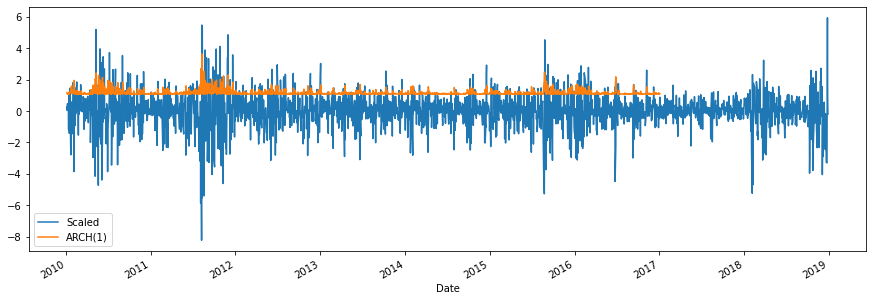

In [22]:
# plot model prediction of insample conditional volatility
df2["ARCH(1)"] = res_arch1.conditional_volatility
df2[['Scaled','ARCH(1)']].plot(figsize=(15,5))
# so, fit seems to be just ok, it seems underestimate when values are large & over estimate when values are small.

In [23]:
# now forecast
res_arch1.forecast(horizon=Ntest) 
# shows warning about reindex that already we've seen in code preparation

C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [24]:
fcast_arch1 = res_arch1.forecast(horizon=Ntest, reindex = True) # set reindex argument ot true

In [25]:
# print out return value to see what kind of object it is
fcast_arch1
# so it is a type archmodelforecast

In [26]:
fcast_arch1.mean  # As this(fcast_arch1) object has arrtibutes mean,variance...
# we get back a dataframe that contain all the dates of our original time series (even dates don't have forecast set to Nan)
# only final rows has actual numbers This is because we did'nt specify a value for the start argumen (so this assume that
# we only want to forecast from the end of the training series)
# all these mean values is same becoz default mean model is constant

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# check variance
fcast_arch1.variance
# similar to mean we get full size dataframe even these value is Nan and variance forecast stored in final row 

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# check residual variance (as we know when we use constant/zero mean this will be same as variance)
fcast_arch1.residual_variance 

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Now call forecast fun again and set reindex = false
fcast_arch1 = res_arch1.forecast(horizon=Ntest, reindex = False)

In [30]:
fcast_arch1.mean
# As we have forecast for final date this is the only row that shows in dataframe     

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,...,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031


In [31]:
fcast_arch1.variance
# not have any row having Nan

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.284314,1.379741,1.396637,1.399629,1.400159,1.400253,1.400269,1.400272,1.400273,1.400273,...,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273


<AxesSubplot:xlabel='Date'>

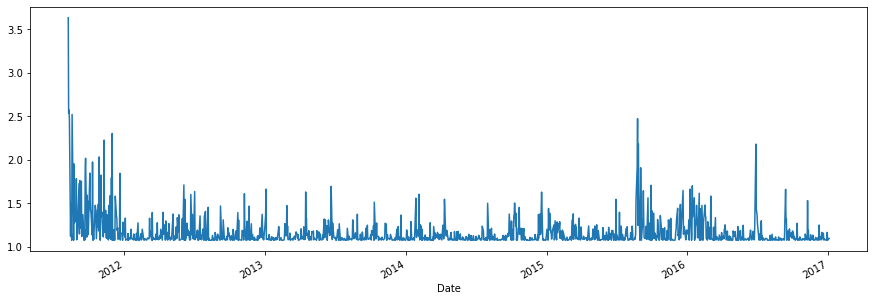

In [32]:
# now we know how forecast fun works now see how our model behave
# so, ploting conditional volatility that our model has learned from some arbitarary date (stored in col ARCH(1))
df2.loc['2011-08-09':]['ARCH(1)'].plot(figsize=(15,5))
# chose this specific date becoz conditional volatility has very high value compaires to others & we want to observe how 
# does forecast evolve over time starting from this value  

In [33]:
fcast_arch1  = res_arch1.forecast(horizon = Ntest, reindex=True, start='2011-08-01') # start must include date of intrest

In [34]:
# check variance of forecast for the surrounded dates 
fcast_arch1.variance['2011-07-28':'2011-08-05']
# this we can observe that any date before start date we passed in forecast will have Nan

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2011-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.211915,1.366921,1.394367,1.399227,1.400088,1.400240,1.400267,1.400272,1.400273,1.400273,...,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273
2011-08-02,2.972328,1.678627,1.449559,1.409000,1.401818,1.400546,1.400321,1.400281,1.400274,1.400273,...,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273
2011-08-03,1.214825,1.367437,1.394459,1.399243,1.400090,1.400241,1.400267,1.400272,1.400273,1.400273,...,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273
2011-08-04,7.294964,2.444009,1.585081,1.432996,1.406067,1.401299,1.400454,1.400305,1.400278,1.400274,...,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273
2011-08-05,1.162906,1.358244,1.392831,1.398955,1.400039,1.400231,1.400265,1.400271,1.400273,1.400273,...,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273


In [35]:
fcast_arch1.variance.loc['2011-08-09'].to_numpy().shape
# get shape of single row of variance forecast (500 we set for horizon)

(500,)

In [36]:
# to get index of date we are intrested 
df2.index.get_loc('2011-08-09')
# we will like to know what date is 500 steps ahead, since that will be our end of forecast

402

In [37]:
# check index value at
df2.index[402+500]  # this represent end of forecast 

Timestamp('2013-08-06 00:00:00')

In [38]:
# now store our variance forecast in df2 dataframe, 1st index in loc fun,for the 2nd index create a new col ARCH(1) forecast
# get variance forecast for 2011-08-09 and convery it into numpy array since we don't want to represent it as series/dataframe
# becoz if we use series/dataframe it would not have right indixes to match up with df2
df2.loc['2011-08-10':'2013-08-06', 'ARCH(1) Forecast'] = np.sqrt(fcast_arch1.variance.loc['2011-08-09'].to_numpy())
# taknig sqrt becoz we want volatility

<AxesSubplot:xlabel='Date'>

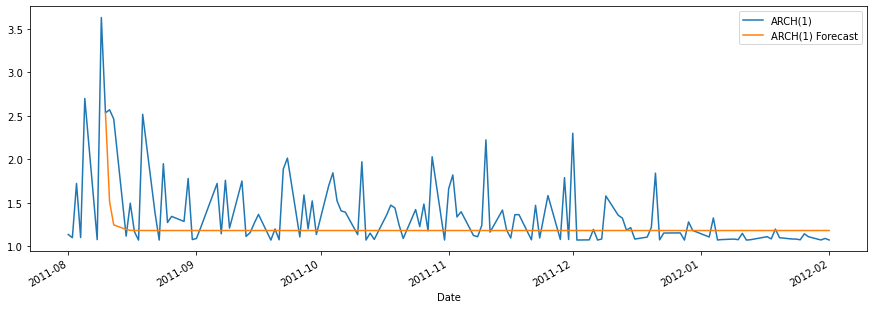

In [39]:
# plot forecast along with predicted conditional volatility
df2.loc['2011-08-01':'2012-02-01'][['ARCH(1)','ARCH(1) Forecast']].plot(figsize=(15,5)) 
# note: we set the dated to surrounded at the begninning of our forecast, but to cutoff arounf 2012 and forecast will 
# converge faster than full 500 steps.
# see that volatility forecast start at very high value and goes lower and lower until it converges 

In [40]:
# now to get the index for another specially chosen date, which is 2011-08-17, reason to choose this date is because this 
# date have an uncharacteristically low volatility. The goal of all this is to see nomatter where the volatility starts from
# they end up converging to same value 
fcast_arch1.variance.index.get_loc('2011-08-17')

408

In [41]:
df2.index[408+500]  # end date of forecast

Timestamp('2013-08-14 00:00:00')

In [42]:
 # now grab the forecast for 2nd date and store in our dataframe
 # same as earlier except different date and have stored this in new col 'ARCH(1) Forecast low'   
df2.loc['2011-08-18':'2013-08-14', 'ARCH(1) Forecast Low'] = np.sqrt(fcast_arch1.variance.loc['2011-08-17'].to_numpy())

<AxesSubplot:xlabel='Date'>

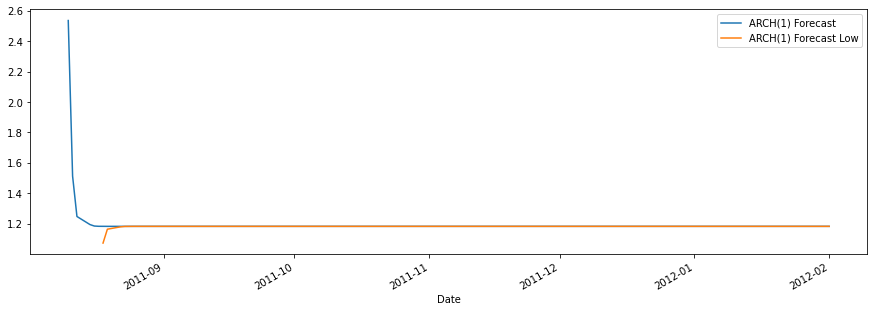

In [43]:
# now plot both forecast @ the same time 
plot_cols = ['ARCH(1) Forecast', 'ARCH(1) Forecast Low']
df2.loc['2011-08-01':'2012-02-01'][plot_cols].plot(figsize=(15,5)) 
# the result is same as what we expect, no matter what the starting volatility is, both forecasts end up converging to the 
# same value.

In [44]:
# Next step is to show that this value (which the forecasts converge to is actually the theoritical, unconditional variance)
# from above res_arch1 look at params attribute
res_arch1.params

mu          0.015031
omega       1.152335
alpha[1]    0.177064
Name: params, dtype: float64

In [45]:
# use formula we drive for unconditional variance 
res_arch1.params['omega'] / (1-res_arch1.params['alpha[1]'])

1.4002727804834507

In [46]:
# now check final value of our 1st forecast 
fcast_arch1.variance.loc['2011-08-17'].to_numpy()[-1]
# so final value is same 

1.4002727804834507

In [47]:
# check for final value of 2nd forecast which start at very low no 
fcast_arch1.variance.loc['2011-08-09'].to_numpy()[-1]
# final value is still the same 

1.400272780483451

# GARCH(1,1)

In [48]:
# now consider a full Garch model GARCH(1,1) most popular garch becoz it fits finantial time series very well
garch11 = arch_model(train['Scaled'], vol='GARCH',p=1,q=1)
# last 3 arguments (vol,p,q) are not necessary becoz these are default value 

In [49]:
res_garch11 = garch11.fit(update_freq=10)

Iteration:     10,   Func. Count:     62,   Neg. LLF: 2570.1176198361004
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2570.1176156685015
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12


In [50]:
res_garch11.summary()
# notice that log(likelihood) in AIC is much better than before this is sign that this model is much better fit.
# beta1 coefficient is very small p value indicating that it is very significant This make sense given the improvement in
# the likelihood 

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 Scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2570.12
Distribution:                  Normal   AIC:                           5148.24
Method:            Maximum Likelihood   BIC:                           5170.13
                                        No. Observations:                 1762
Date:                Mon, Jul 24 2023   Df Residuals:                     1761
Time:                        15:23:19   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0340  2.213e-02      1.538      0.124 [-9.336e-03,7.740e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0660  1.492e-02      4.427  9.560e-06 [3.680e-02,9.528e-02]
alpha[1]       0.1499  2.499e-02      6.000  1.971e-09     [  0.101,  0.199]
beta[1]        0.8021  2.545e-02     31.515 5.447e-218     [  0.752,  0.852]
============================================================================

Covariance estimator: robust
"""

<AxesSubplot:xlabel='Date'>

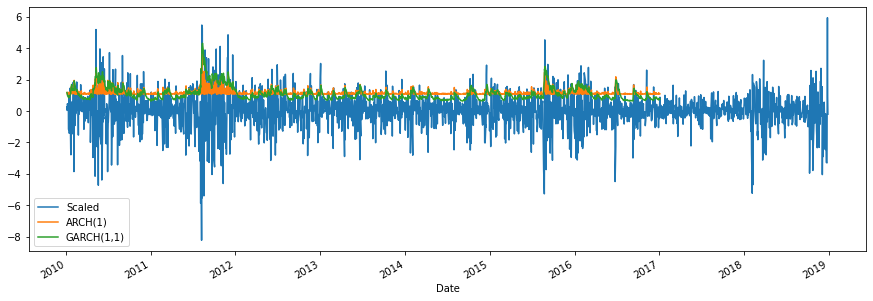

In [51]:
# store the conditional volatility in df2 dataframe by col name Garch(1,1) and plot this along with ARCH(1) & original
# scaled time series
df2['GARCH(1,1)'] = res_garch11.conditional_volatility
df2[['Scaled', 'ARCH(1)', 'GARCH(1,1)']].plot(figsize=(15,5))

In [52]:
# Now make forecast using the same start date as before
# as we chose this start date becoz value is very high on this date so we expect to see forecast converge downwards
fcast_garch11 = res_garch11.forecast(horizon = Ntest, reindex=False, start='2011-08-09')

In [53]:
# Now store the variance forecast same as before
df2.loc['2011-08-10':'2013-08-06', 'GARCH(1,1) Forecast'] = np.sqrt(fcast_garch11.residual_variance.loc['2011-08-09'].to_numpy())

In [54]:
# Now compute absolute value of scaled time series & Note that time series itself is on the same scale as the volatility OR
# while square of time series is on same scale as variance, so pick one that used 
df2['AbsScaled'] = df2['Scaled'].abs()

<AxesSubplot:xlabel='Date'>

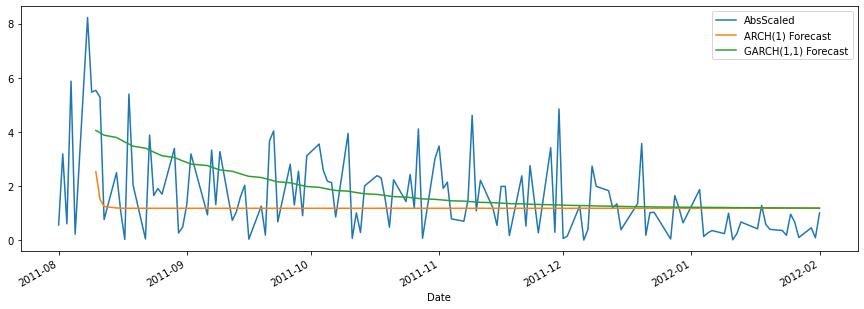

In [55]:
# now plot Scaled time series with ARCH(1) forecast and GARCH(1,1) forecast
plot_cols = ['AbsScaled', 'ARCH(1) Forecast', 'GARCH(1,1) Forecast']
df2.loc['2011-08-01':'2012-02-01'][plot_cols].plot(figsize=(15,5))
# Notice :-> Garchmodel matches actual data much more closely , Arch(1) seems to not be able to reach those high values.
#        :->  How quickly Arch(1) model converges compaire to Garch(1,1)
# So Garch model is much more persistance 

In [56]:
# One possible option when we create Garch what kind of distribution to use (by default NORMAL) but student t distribution
# may be a better fit for finantial returns 
# so create another Garch(1,1) but now using 'StudentsT' distribution (in place of default normal) 
garch11t = arch_model(train['Scaled'], vol = 'GARCH', p = 1, q = 1, dist = 'StudentsT')

In [57]:
# call model.fit
res_garch11t = garch11t.fit(update_freq=10)

Iteration:     10,   Func. Count:     74,   Neg. LLF: 2531.192054266944
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2531.1894603794362
            Iterations: 14
            Function evaluations: 97
            Gradient evaluations: 14


In [58]:
res_garch11t.summary
# log(likelihood) again improved as has AIC and all Garch parameters are significant and note that there is one more 
# parameter under distribution as T distribution has parameter called nu which is degree_of_freedom, this also has 
# significant p value 

<bound method ARCHModelResult.summary of                         Constant Mean - GARCH Model Results                         
Dep. Variable:                       Scaled   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2531.19
Distribution:      Standardized Student's t   AIC:                           5072.38
Method:                  Maximum Likelihood   BIC:                           5099.75
                                              No. Observations:                 1762
Date:                      Mon, Jul 24 2023   Df Residuals:                     1761
Time:                              15:23:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------

<AxesSubplot:xlabel='Date'>

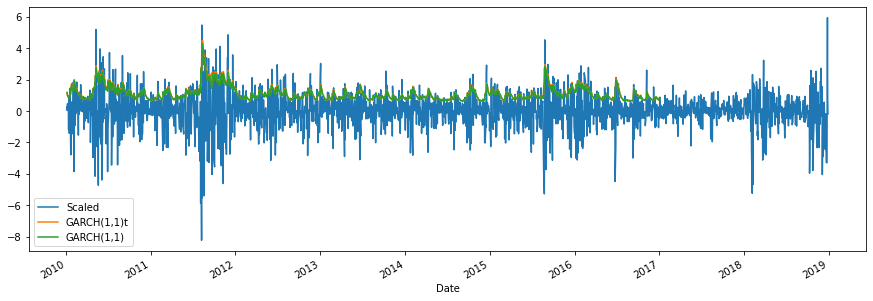

In [59]:
# now again store conditional volatility and plot the result 
df2['GARCH(1,1)t'] = res_garch11t.conditional_volatility
df2[['Scaled', 'GARCH(1,1)t', 'GARCH(1,1)']].plot(figsize=(15,5))
# zoom in to differences more clearly

In [60]:
# now compute the forecast
fcast_garch11t = res_garch11t.forecast(horizon = Ntest, reindex=False, start='2011-08-09')

In [61]:
# store the forecast same date as before
df2.loc['2011-08-10':'2013-08-06', 'GARCH(1,1)t Forecast'] = np.sqrt(fcast_garch11t.residual_variance.loc['2011-08-09'].to_numpy())

<AxesSubplot:xlabel='Date'>

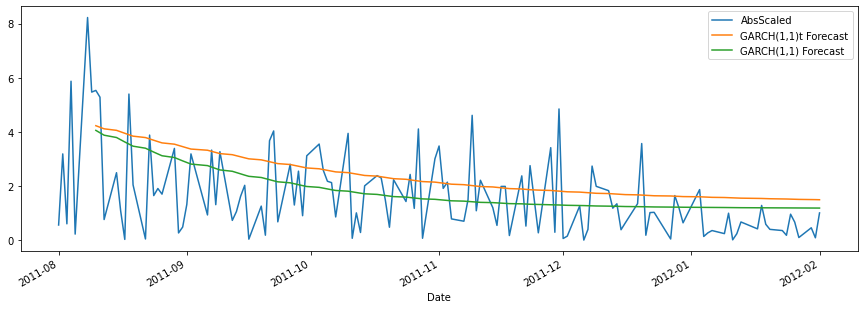

In [62]:
# plot the forecast for both garch model we created 
plot_cols = ['AbsScaled', 'GARCH(1,1)t Forecast', 'GARCH(1,1) Forecast']
df2.loc['2011-08-01':'2012-02-01'][plot_cols].plot(figsize=(15,5))
# Note :-> new model seems to reach an even high value and it seems to have even more persistence than the Garch(1,1) Normal


# GARCH(p,q)

In [63]:
garchpq = arch_model(train['Scaled'], p=8, q=5, dist='StudentsT')
# choose p,q value you like & again using T distribution as we've seen it works well with only one extra parameters  

In [64]:
res_garchpq = garchpq.fit(update_freq=10)

Iteration:     10,   Func. Count:    185,   Neg. LLF: 2678.2824969568774
Iteration:     20,   Func. Count:    368,   Neg. LLF: 2525.5366928782078
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2525.288222040507
            Iterations: 29
            Function evaluations: 520
            Gradient evaluations: 29


In [65]:
res_garchpq.summary()
# See that log(likelihood) has improved slightly now intrestingly when look at garch coefficients we see that many of them 
# have not significant p-value   

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                       Scaled   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2525.29
Distribution:      Standardized Student's t   AIC:                           5082.58
Method:                  Maximum Likelihood   BIC:                           5170.16
                                              No. Observations:                 1762
Date:                      Mon, Jul 24 2023   Df Residuals:                     1761
Time:                              15:23:42   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0579  2.018e-02      2.869  4.119e-03 [1.834e-02,9.744e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1896      0.126      1.510      0.131 [-5.656e-02,  0.436]
alpha[1]       0.0751  3.299e-02      2.278  2.273e-02  [1.049e-02,  0.140]
alpha[2]       0.2069  8.145e-02      2.540  1.107e-02  [4.728e-02,  0.367]
alpha[3]       0.0828      0.196      0.423      0.672    [ -0.301,  0.466]
alpha[4]   2.4421e-11      0.110  2.224e-10      1.000    [ -0.215,  0.215]
alpha[5]       0.0328      0.147      0.222      0.824    [ -0.256,  0.321]
alpha[6]       0.0383  6.546e-02      0.585      0.559 [-9.003e-02,  0.167]
alpha[7]       0.0259  8.825e-02      0.293      0.769    [ -0.147,  0.199]
alpha[8]       0.0361  4.227e-02      0.853      0.394 [-4.679e-02,  0.119]
beta[1]    4.8373e-11      0.902  5.360e-11      1.000    [ -1.769,  1.769]
beta[2]        0.3957      0.451      0.877      0.380    [ -0.488,  1.280]
beta[3]    6.0033e-12      0.842  7.131e-12      1.000    [ -1.650,  1.650]
beta[4]    5.8148e-11      0.437  1.330e-10      1.000    [ -0.857,  0.857]
beta[5]    8.8395e-12      0.523  1.689e-11      1.000    [ -1.026,  1.026]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.7059      0.771      7.398  1.383e-13 [  4.194,  7.218]
========================================================================

Covariance estimator: robust
"""

In [66]:
# so one might assume that becoz garchpq model has better likelihood that this is our choice, However Statisticians prefer 
# to use AIC. so check AIC for each of our model
res_arch1.aic, res_garch11.aic, res_garch11t.aic, res_garchpq.aic
# so Arch(1) is by far the worst, Garch(1,1) Normal was significant improvement, but Garch(1,1)t improve the AIC even more
# In this case we regect the Garch(p,q) i.e. Garch(8,5) becoz it give worse AIC

(5523.987402181205, 5148.235231337003, 5072.3789207588725, 5082.576444081014)

<AxesSubplot:xlabel='Date'>

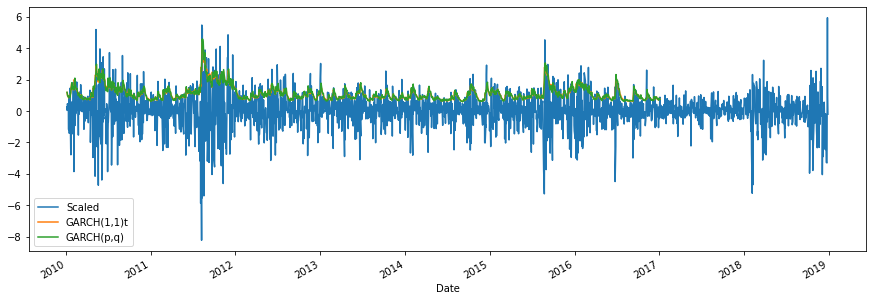

In [67]:
# now again store conditional volatility and plot the result 
df2['GARCH(p,q)'] = res_garchpq.conditional_volatility
df2[['Scaled', 'GARCH(1,1)t', 'GARCH(p,q)']].plot(figsize=(15,5))
# so they are very close 

In [68]:
  # now compute the forecast
fcast_garchpq = res_garchpq.forecast(horizon = Ntest, reindex=False, start='2011-08-09')

In [69]:
# store the forecast same date as before
df2.loc['2011-08-10':'2013-08-06', 'GARCH(p,q) Forecast'] = np.sqrt(fcast_garchpq.residual_variance.loc['2011-08-09'].to_numpy())

<AxesSubplot:xlabel='Date'>

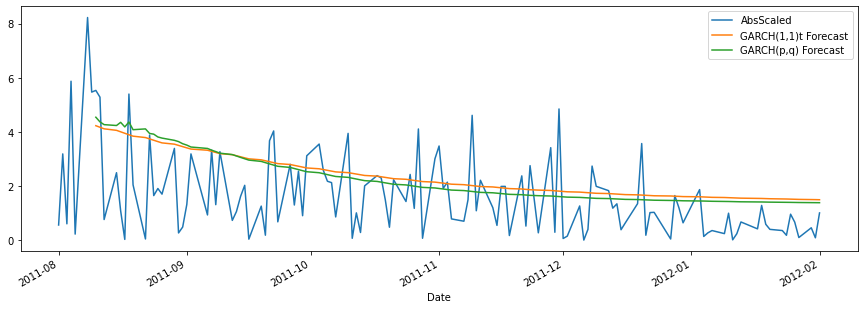

In [70]:
# plot the forecast for against our best model so far 
plot_cols = ['AbsScaled', 'GARCH(1,1)t Forecast', 'GARCH(p,q) Forecast']
df2.loc['2011-08-01':'2012-02-01'][plot_cols].plot(figsize=(15,5))
# as seen their is no advantage of using Garch(p,q)

In [71]:
# Now plot the forecast for test set, which we haven't yet done, we do using Garch(p,q) only because it's the last model 
# we created
train_idx = df2.index <= train.index[-1]
test_idx = ~train_idx

In [72]:
# store train prediction using conditional volatility 
# also store test prediction using the sqrt of variance of the forecasts.
df2.loc[train_idx, 'GARCH(p,q) Train'] = res_garchpq.conditional_volatility
df2.loc[test_idx, 'GARCH(p,q) Test'] = np.sqrt(fcast_garchpq.variance.iloc[-1].to_numpy()) 


<AxesSubplot:xlabel='Date'>

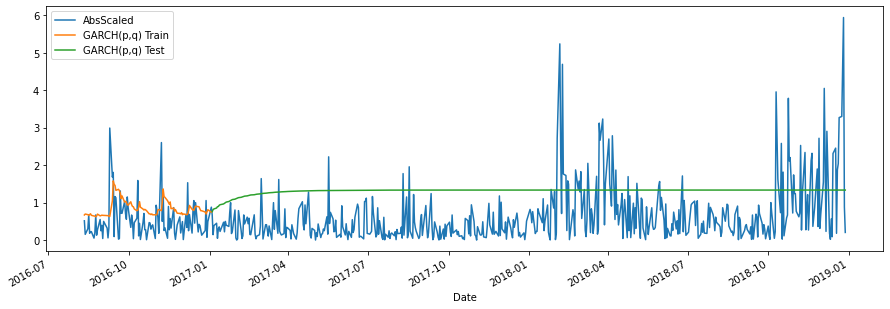

In [73]:
# plot train and test prediction
plot_cols = ['AbsScaled', 'GARCH(p,q) Train', 'GARCH(p,q) Test']
df2.iloc[-(Ntest+100):][plot_cols].plot(figsize=(15,5))

 So as expected for the test set, the forecast of the variance simply converges to the unconditional value (the actual long term variance)
 does not follow this pattern =, However prediction seems to be somewhere in the middle below the highest value, but above the lowest value
 as mentioned earlier WE DONT EXPECT ANY MODEL TO PREDICT RANDOM VOLATILITY FLUCTUATUION SEVERAL YEARS AHEAD it simply would't make sense